In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns;
%matplotlib inline

## Load meta data

In [2]:
import sqlite3
conn = sqlite3.connect("/data/glucolytes/S5_data.db")


In [3]:
df_meta = pd.read_sql_query("SELECT * from clinical", conn)



df_meta.head()

userID   Age   BMI  A1C    FBG  ogtt.2hr  insulin  hs.CRP  Tchol  \
0  1636-69-001  59.0  21.7  6.7  109.0     205.0      9.0     0.3  204.0   
1  1636-69-026  67.0  28.9  6.2   97.0     152.0      7.0     1.2  208.0   
2  1636-69-028  50.0  27.3  5.2   91.0     121.0      4.0     4.4  127.0   
3  1636-69-032  59.0  25.0  5.7   82.0     142.0      5.0     0.2  224.0   
4  1636-69-035  60.0  28.2  5.5   87.0     118.0      NaN     0.2  224.0   

     Trg  ...   freq_low  freq_moderate  freq_severe  glucotype  Height  \
0  135.0  ...   0.147059       0.369748     0.483193     severe   176.3   
1   76.0  ...   0.004202       0.289916     0.705882     severe   157.5   
2   25.0  ...   0.008403       0.424370     0.567227     severe     NaN   
3  138.0  ...   0.021008       0.491597     0.487395   moderate   169.4   
4   85.0  ...   0.029412       0.352941     0.617647     severe   176.5   

   Weight  Insulin_rate_dd  perc_cgm_prediabetic_range  \
0    68.0          0.10150                    0.190404   
1    76.0              NaN                   0.0831202   
2     NaN              NaN                   0.0714286   
3    68.2          0.01575                   0.0147643   
4    82.5          0.05642                     0.15465   

   perc_cgm_diabetic_range  SSPG  
0                0.0262106    91  
1                        0   133  
2                0.0015444    75  
3                        0    87  
4               0.00592128   160  

[5 rows x 49 columns]

## Load meal data

In [4]:
df_meals = pd.read_csv("/data/glucolytes/S6_Data.tsv", sep = "\t")

df_meals.time = pd.to_datetime(df_meals.time)
df_meals.GlucoseValue = pd.to_numeric(df_meals.GlucoseValue, errors="coerce")

df_meals.shape

(6152, 4)

In [5]:
df_meals.head()

Meal    userID                time  GlucoseValue
0  PB 1  2133-001 2016-08-04 08:10:00          81.0
1  PB 1  2133-001 2016-08-04 08:15:00          78.0
2  PB 1  2133-001 2016-08-04 08:20:00          77.0
3  PB 1  2133-001 2016-08-04 08:25:00          79.0
4  PB 1  2133-001 2016-08-04 08:30:00          81.0

In [6]:
z_scaled_glucose = df_meals.groupby([df_meals.Meal, df_meals.userID]).transform(lambda x: (x - x.mean())/x.std())
mean_centered_glucose = df_meals.groupby([df_meals.Meal, df_meals.userID]).transform(lambda x: (x - x.mean()))
baselined_glucose = df_meals.groupby([df_meals.Meal, df_meals.userID]).transform(lambda x: (x - x.iloc[0]))


df_meals["z_scaled_glucose"] = z_scaled_glucose.values
df_meals["mean_centered_glucose"] = mean_centered_glucose.values

In [7]:
baselined_glucose.columns = ["baseline_time", "baseline_glucose"]
baselined_glucose.baseline_glucose = pd.to_numeric(baselined_glucose.baseline_glucose, errors="coerce")
baselined_glucose.baseline_time = pd.to_timedelta(baselined_glucose.baseline_time)
baselined_glucose["baseline_minutes"] = baselined_glucose.baseline_time.apply(lambda x: x.total_seconds()/60)

df_meals = pd.concat([df_meals, baselined_glucose], axis = 1)

In [8]:
df_meals.head()

Meal    userID                time  GlucoseValue  z_scaled_glucose  \
0  PB 1  2133-001 2016-08-04 08:10:00          81.0          0.065086   
1  PB 1  2133-001 2016-08-04 08:15:00          78.0         -0.737645   
2  PB 1  2133-001 2016-08-04 08:20:00          77.0         -1.005222   
3  PB 1  2133-001 2016-08-04 08:25:00          79.0         -0.470068   
4  PB 1  2133-001 2016-08-04 08:30:00          81.0          0.065086   

   mean_centered_glucose baseline_time  baseline_glucose  baseline_minutes  
0               0.243243      00:00:00               0.0               0.0  
1              -2.756757      00:05:00              -3.0               5.0  
2              -3.756757      00:10:00              -4.0              10.0  
3              -1.756757      00:15:00              -2.0              15.0  
4               0.243243      00:20:00               0.0              20.0

In [9]:
unique_groups= df_meals[["Meal", "userID"]].drop_duplicates()

In [10]:
unique_groups.Meal.value_counts()

Bar 2    30
PB 1     30
CF 1     30
CF 2     30
Bar 1    29
PB 2     27
Name: Meal, dtype: int64

In [11]:
unique_groups.userID.value_counts()

2133-022    6
2133-039    6
2133-013    6
2133-040    6
2133-008    6
2133-036    6
2133-026    6
2133-002    6
2133-001    6
2133-004    6
2133-015    6
2133-035    6
2133-030    6
2133-012    6
2133-032    6
2133-006    6
2133-037    6
2133-024    6
2133-020    6
2133-028    6
2133-019    6
2133-009    6
2133-010    6
2133-033    6
2133-011    6
2133-025    6
2133-021    6
2133-017    5
2133-018    5
2133-041    4
Name: userID, dtype: int64

In [67]:
df_meal = df_meals[(df_meals.Meal == "CF 1") | (df_meals.Meal == "CF 2")]

pd.unique(df_meal.Meal)

array(['CF 1', 'CF 2'], dtype=object)

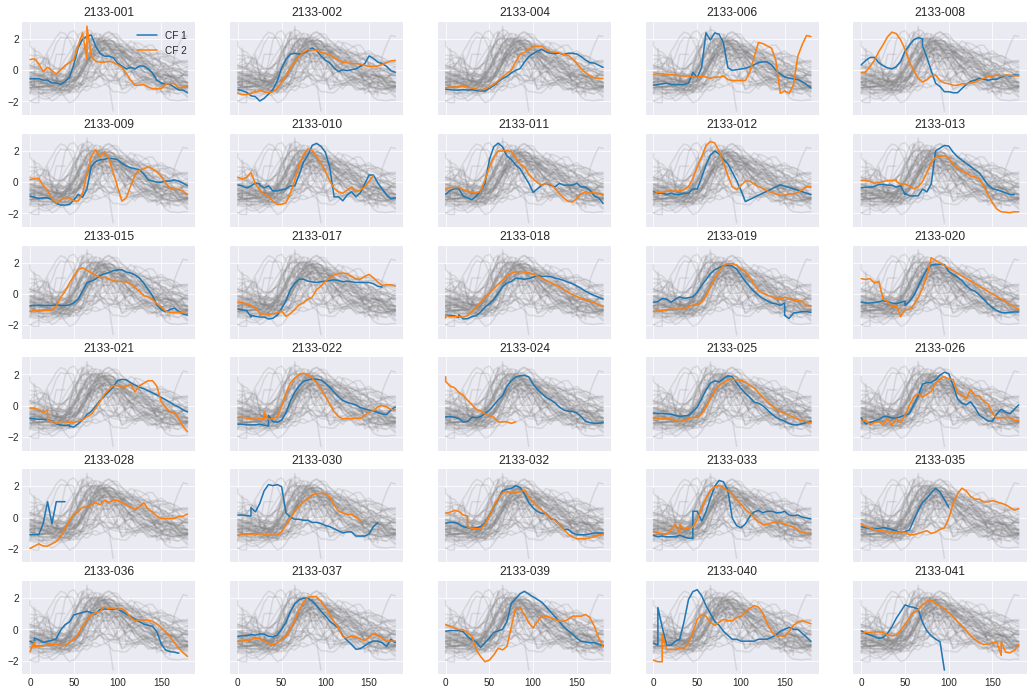

In [68]:
plt.figure(figsize=(18,12))
plt.style.use('seaborn-darkgrid')

for i, highlighted_subject in enumerate(pd.unique(df_meal.userID)):
    plt.subplot(6,5,i+1)

    for subject in pd.unique(df_meal.userID):
        for meal in pd.unique(df_meal.Meal):
            df_meal_subject = df_meal[(df_meal.userID == subject) & (df_meal.Meal == meal)]
            plt.plot(df_meal_subject.baseline_minutes, df_meal_subject.z_scaled_glucose, color = "gray", alpha = .2, label='_nolegend_')
    
    df_subject = df_meal[df_meal.userID == highlighted_subject]
    for meal in pd.unique(df_subject.Meal):
        df_meal_subject = df_subject[df_subject.Meal == meal]
        plt.plot(df_meal_subject.baseline_minutes, df_meal_subject.z_scaled_glucose, label = meal)
    plt.title(highlighted_subject)
    if i == 0:
        plt.legend()

    if i%5 != 0:
        plt.tick_params(labelleft=False)
    if i < (30-5):
        plt.tick_params(labelbottom=False)

        



In [14]:
def compute_gi(glucose_vals):
    return np.sum(glucose_vals/18)/100



In [42]:
df_meal_subject.head()

Meal    userID                time  GlucoseValue  z_scaled_glucose  \
6114  Bar 2  2133-041 2017-07-20 05:00:00          69.0         -0.738801   
6115  Bar 2  2133-041 2017-07-20 05:05:00          67.0         -0.862477   
6116  Bar 2  2133-041 2017-07-20 05:10:00          65.0         -0.986153   
6117  Bar 2  2133-041 2017-07-20 05:15:00          66.0         -0.924315   
6118  Bar 2  2133-041 2017-07-20 05:20:00          67.0         -0.862477   

      mean_centered_glucose baseline_time  baseline_glucose  baseline_minutes  
6114             -11.947368      00:00:00               0.0               0.0  
6115             -13.947368      00:05:00              -2.0               5.0  
6116             -15.947368      00:10:00              -4.0              10.0  
6117             -14.947368      00:15:00              -3.0              15.0  
6118             -13.947368      00:20:00              -2.0              20.0

In [41]:
pd.unique(df_meal_subject.userID)

array(['2133-041'], dtype=object)

In [15]:
gis_df = df_meals.groupby(by = ["userID", "Meal"])[["GlucoseValue"]].apply(compute_gi)

gis_df_clean = pd.DataFrame(gis_df.to_records())

gis_pivot = gis_df_clean.pivot(columns = "Meal", values = "GlucoseValue", index = "userID")

In [16]:
gis_pivot.head()

Meal         Bar 1     Bar 2      CF 1      CF 2      PB 1      PB 2
userID                                                              
2133-001  1.787222  1.885000  1.809444  2.331667  1.660000  1.690556
2133-002  0.600556  2.135556  2.312222  2.823333  1.944444  1.953333
2133-004  2.998889  2.643889  3.604444  3.652222  1.537778  2.673333
2133-006  1.521111  1.449444  1.957778  1.766667  1.431111  1.586667
2133-008  1.994444  1.907222  1.691667  1.576667  1.728889  1.749444

In [17]:
bar_gi_diff = pd.DataFrame(np.abs(gis_pivot["Bar 1"]- gis_pivot["Bar 2"]))
cf_gi_diff  = pd.DataFrame(np.abs(gis_pivot["CF 1"] - gis_pivot["CF 2"]))
pb_gi_diff  = pd.DataFrame(np.abs(gis_pivot["PB 1"] - gis_pivot["PB 2"] ))

In [18]:
gi_diffs = pd.concat([bar_gi_diff, cf_gi_diff, pb_gi_diff], axis = 1)
gi_diffs.columns = ["Bar", "CF", "PB"]

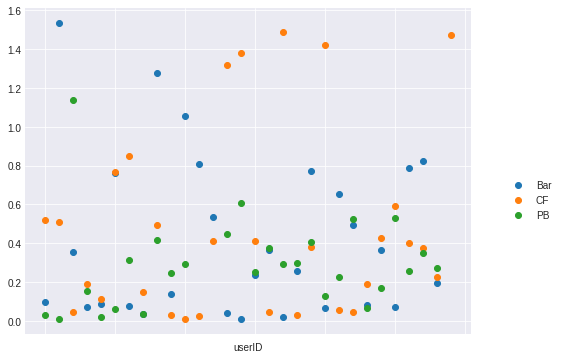

In [19]:
gi_diffs.plot(marker = "o", linestyle = "", figsize=(8,6)).legend(bbox_to_anchor=(1.2, 0.5));

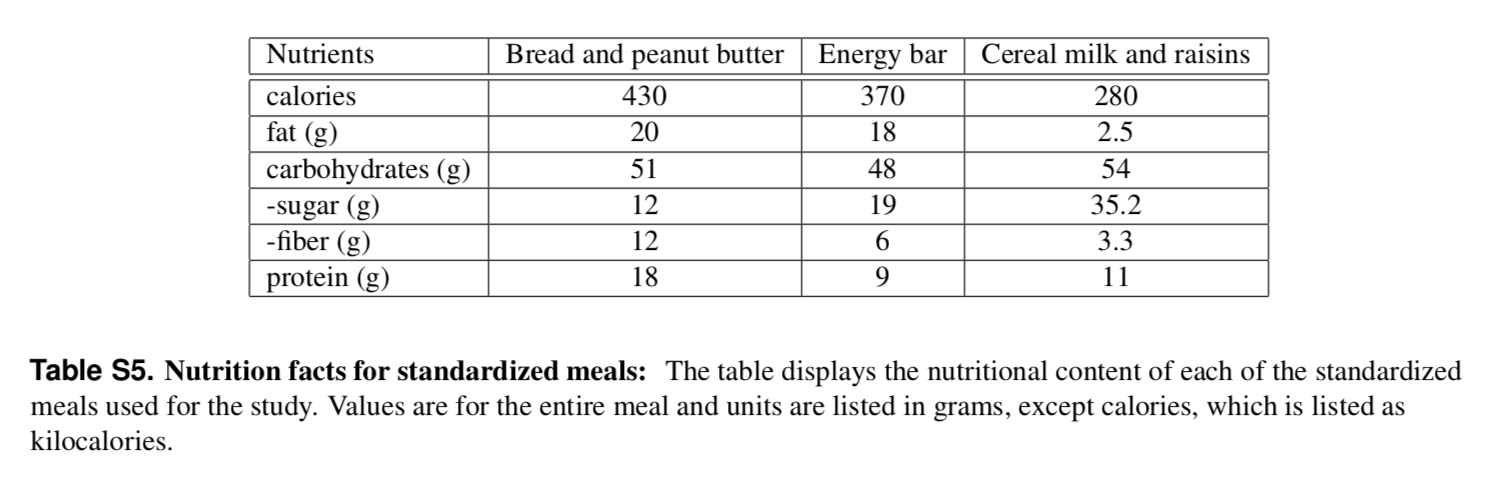

In [20]:
from IPython.display import Image
Image(filename='meals-nutrition.png') 

In [21]:
from sklearn.externals import joblib

In [22]:
clf_model = joblib.load("/home/mehrdad/Dropbox/utils/models/2018-07-19_snyder-gl-predictor-RF.pkl") 

In [23]:
clf_model.keys()

dict_keys(['features', 'sklean_rf'])

In [24]:
clf_model['features']

['Energy',
 'Total lipid (fat)',
 'Carbohydrate, by difference',
 'Sugars, total',
 'Fiber, total dietary',
 'Protein']

In [25]:
clf = clf_model['sklean_rf']

In [26]:
PB = 10**clf.predict(np.atleast_2d([430, 20, 51, 12, 12, 18]))
EB = 10**clf.predict(np.atleast_2d([370, 18, 48, 19, 6, 9]))
CF = 10**clf.predict(np.atleast_2d([280, 2.5, 54, 35.2, 3.3, 11]))

In [27]:
PB

array([24.98381177])

In [28]:
EB

array([28.76598249])

In [29]:
CF

array([25.84772787])

In [30]:
knn_model = joblib.load("/home/mehrdad/Dropbox/utils/models/2018-07-24_snyder-gl-predictor-KNN.pkl") 

In [31]:
knn_model.keys()

dict_keys(['features', 'sklean_knn'])

In [33]:
clf = knn_model["sklean_knn"]

In [34]:
PB = 10**clf.predict(np.atleast_2d([430, 20, 51, 12, 12, 18]))
EB = 10**clf.predict(np.atleast_2d([370, 18, 48, 19, 6, 9]))
CF = 10**clf.predict(np.atleast_2d([280, 2.5, 54, 35.2, 3.3, 11]))

In [35]:
PB

array([27.90784235])

In [36]:
EB

array([34.61388713])

In [37]:
CF

array([32.25765214])

In [43]:
ogtt_and_more = pd.read_csv("/data/glucolytes/journal.pbio.2005143.s017.tsv", sep = "\t")

In [44]:
ogtt_and_more.head()

userID        date  timepoint_mins   value     parameter
0  1636-69-001  2013-11-11             0.0   900.6  Calculated_C
1  1636-69-001  2013-11-11            15.0  1091.2  Calculated_C
2  1636-69-001  2013-11-11            30.0  1349.1  Calculated_C
3  1636-69-001  2013-11-11            45.0  1649.7  Calculated_C
4  1636-69-001  2013-11-11            60.0  1981.7  Calculated_C

In [45]:
pd.unique(ogtt_and_more.parameter)

array(['Calculated_C', 'FBG', 'Insulin_Rate', 'Insulin_uuml',
       'Measured_C', 'OGTT', 'insulin', 'SSPG'], dtype=object)

In [46]:
ogtt_df = ogtt_and_more[ogtt_and_more.parameter == "OGTT"]

In [47]:
ogtt_df.head()

userID        date  timepoint_mins  value parameter
31  1636-69-001  2013-11-11             0.0  147.0      OGTT
32  1636-69-001  2013-11-11            30.0  197.0      OGTT
33  1636-69-001  2013-11-11           120.0  205.0      OGTT
68  1636-69-026  2016-11-30             0.0   91.0      OGTT
69  1636-69-026  2016-11-30            30.0  182.0      OGTT

In [48]:
ogtt_df_subject = ogtt_df[ogtt_df.userID == "1636-69-001"]

In [50]:
ogtt_df_subject

userID        date  timepoint_mins  value parameter
31  1636-69-001  2013-11-11             0.0  147.0      OGTT
32  1636-69-001  2013-11-11            30.0  197.0      OGTT
33  1636-69-001  2013-11-11           120.0  205.0      OGTT

In [51]:
pd.unique(ogtt_df.timepoint_mins)

array([  0.,  30., 120.])

In [53]:
pd.unique(df_meals.baseline_minutes)

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  55.,
        60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105., 110.,
       115., 120., 125., 130., 135., 140., 145., 150., 155., 160., 165.,
       170., 175., 180.,  50.])

In [56]:
df_meals_ogtt_times = df_meals[(df_meals.baseline_minutes == pd.unique(ogtt_df.timepoint_mins)[0]) |
                               (df_meals.baseline_minutes == pd.unique(ogtt_df.timepoint_mins)[1]) |
                               (df_meals.baseline_minutes == pd.unique(ogtt_df.timepoint_mins)[2]) ]

In [58]:
df_meals_ogtt_times.head()

Meal    userID                time  GlucoseValue  z_scaled_glucose  \
0   PB 1  2133-001 2016-08-04 08:10:00          81.0          0.065086   
7   PB 1  2133-001 2016-08-04 08:40:00          77.0         -1.005222   
24  PB 1  2133-001 2016-08-04 10:10:00          83.0          0.600241   
37  PB 2  2133-001 2016-08-06 08:30:00          74.0         -0.892430   
43  PB 2  2133-001 2016-08-06 09:00:00          70.0         -1.479656   

    mean_centered_glucose baseline_time  baseline_glucose  baseline_minutes  
0                0.243243      00:00:00               0.0               0.0  
7               -3.756757      00:30:00              -4.0              30.0  
24               2.243243      02:00:00               2.0             120.0  
37              -6.078947      00:00:00               0.0               0.0  
43             -10.078947      00:30:00              -4.0              30.0

In [59]:
ogtt_df.head()

userID        date  timepoint_mins  value parameter
31  1636-69-001  2013-11-11             0.0  147.0      OGTT
32  1636-69-001  2013-11-11            30.0  197.0      OGTT
33  1636-69-001  2013-11-11           120.0  205.0      OGTT
68  1636-69-026  2016-11-30             0.0   91.0      OGTT
69  1636-69-026  2016-11-30            30.0  182.0      OGTT

In [73]:
df_ogtt_area = pd.DataFrame(ogtt_df.groupby(["userID"])["value"].sum())

In [77]:
df_ogtt_area.columns = ["ogtt_auc"]

In [78]:
df_meals_ogtt = pd.merge(df_ogtt_area, df_meals_ogtt_times, left_index=True, right_on="userID")

In [80]:
df_meals_ogtt["Glucose_divided_by_ogtt_auc"] = df_meals_ogtt["GlucoseValue"]/df_meals_ogtt["ogtt_auc"]

In [81]:
df_meals_ogtt.head()

ogtt_auc  Meal    userID                time  GlucoseValue  \
0      286.0  PB 1  2133-001 2016-08-04 08:10:00          81.0   
7      286.0  PB 1  2133-001 2016-08-04 08:40:00          77.0   
24     286.0  PB 1  2133-001 2016-08-04 10:10:00          83.0   
37     286.0  PB 2  2133-001 2016-08-06 08:30:00          74.0   
43     286.0  PB 2  2133-001 2016-08-06 09:00:00          70.0   

    z_scaled_glucose  mean_centered_glucose baseline_time  baseline_glucose  \
0           0.065086               0.243243      00:00:00               0.0   
7          -1.005222              -3.756757      00:30:00              -4.0   
24          0.600241               2.243243      02:00:00               2.0   
37         -0.892430              -6.078947      00:00:00               0.0   
43         -1.479656             -10.078947      00:30:00              -4.0   

    baseline_minutes  Glucose_divided_by_ogtt_auc  
0                0.0                     0.283217  
7               30.0                     0.269231  
24             120.0                     0.290210  
37               0.0                     0.258741  
43              30.0                     0.244755

In [85]:
gis_df = df_meals_ogtt.groupby(["userID", "Meal"])[["Glucose_divided_by_ogtt_auc"]].sum()

In [87]:
gis_df_clean.head()

userID   Meal  Glucose_divided_by_ogtt_auc
0  2133-001  Bar 1                     0.860140
1  2133-001  Bar 2                     1.027972
2  2133-001   CF 1                     0.874126
3  2133-001   CF 2                     1.188811
4  2133-001   PB 1                     0.842657

In [88]:
gis_df_clean = pd.DataFrame(gis_df.to_records())

gis_pivot = gis_df_clean.pivot(columns = "Meal", values = "Glucose_divided_by_ogtt_auc", index = "userID")

In [103]:
gis_pivot.head()

Meal         Bar 1     Bar 2      CF 1      CF 2      PB 1      PB 2
userID                                                              
2133-001  0.860140  1.027972  0.874126  1.188811  0.842657  0.790210
2133-002  0.490964  0.834337  0.852410  0.969880  0.810241  0.765060
2133-004  2.339181  2.216374  2.783626  2.836257  1.456140  2.257310
2133-006  0.802326  0.751938  0.988372  1.058140  0.705426  0.833333
2133-009  0.939490  1.057325  1.050955  0.831210  0.929936  0.773885

In [129]:
gis_pivot.describe()

Meal       Bar 1      Bar 2       CF 1       CF 2       PB 1       PB 2
count  27.000000  28.000000  28.000000  28.000000  28.000000  25.000000
mean    0.817350   0.806084   0.828248   0.903013   0.810381   0.813934
std     0.337129   0.336169   0.418878   0.409849   0.221857   0.337965
min     0.488304   0.231947   0.422319   0.570694   0.400438   0.225383
25%     0.684528   0.637107   0.648284   0.733053   0.681196   0.722022
50%     0.763006   0.772324   0.777424   0.826084   0.753638   0.765060
75%     0.847515   0.837647   0.873269   0.948865   0.844421   0.825581
max     2.339181   2.216374   2.783626   2.836257   1.456140   2.257310

In [104]:
gis_pivot["subject"] = gis_pivot.index

In [107]:
gis_pivot.head()

Signature: gis_pivot.melt(id_vars=None, value_vars=None, var_name=None, value_name='value', col_level=None)
Docstring:
"Unpivots" a DataFrame from wide format to long format, optionally
leaving identifier variables set.

This function is useful to massage a DataFrame into a format where one
or more columns are identifier variables (`id_vars`), while all other
columns, considered measured variables (`value_vars`), are "unpivoted" to
the row axis, leaving just two non-identifier columns, 'variable' and
'value'.

.. versionadded:: 0.20.0

Parameters
----------
frame : DataFrame
id_vars : tuple, list, or ndarray, optional
    Column(s) to use as identifier variables.
value_vars : tuple, list, or ndarray, optional
    Column(s) to unpivot. If not specified, uses all columns that
    are not set as `id_vars`.
var_name : scalar
    Name to use for the 'variable' column. If None it uses
    ``frame.columns.name`` or 'variable'.
value_name : scalar, default 'value'
    Name to use for the 'valu

In [108]:
melt_gis_pivot = gis_pivot.melt(id_vars=["subject",])

In [109]:
melt_gis_pivot.head()

subject   Meal     value
0  2133-001  Bar 1  0.860140
1  2133-002  Bar 1  0.490964
2  2133-004  Bar 1  2.339181
3  2133-006  Bar 1  0.802326
4  2133-009  Bar 1  0.939490

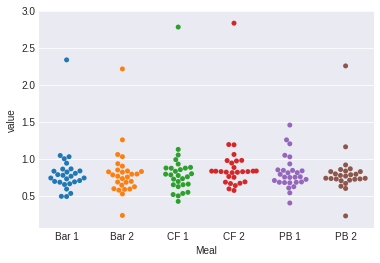

In [99]:
sns.swarmplot(x = "Meal", y = "value", data = gis_pivot.melt())

In [110]:
df_meta_gi = pd.merge(melt_gis_pivot, df_meta, left_on="subject", right_on="userID")

In [120]:
melt_gis_pivot.shape

(168, 3)

In [121]:
df_meta.shape

(57, 49)

In [122]:
df_meta_gi.shape

(168, 52)

In [111]:
df_meta_gi.head()

subject   Meal     value    userID   Age   BMI  A1C   FBG  ogtt.2hr  \
0  2133-001  Bar 1  0.860140  2133-001  27.0  26.4  5.2  86.0     101.0   
1  2133-001  Bar 2  1.027972  2133-001  27.0  26.4  5.2  86.0     101.0   
2  2133-001   CF 1  0.874126  2133-001  27.0  26.4  5.2  86.0     101.0   
3  2133-001   CF 2  1.188811  2133-001  27.0  26.4  5.2  86.0     101.0   
4  2133-001   PB 1  0.842657  2133-001  27.0  26.4  5.2  86.0     101.0   

   insulin   ...    freq_low  freq_moderate  freq_severe  glucotype  Height  \
0      7.0   ...    0.722689       0.168067     0.109244        low   168.0   
1      7.0   ...    0.722689       0.168067     0.109244        low   168.0   
2      7.0   ...    0.722689       0.168067     0.109244        low   168.0   
3      7.0   ...    0.722689       0.168067     0.109244        low   168.0   
4      7.0   ...    0.722689       0.168067     0.109244        low   168.0   

   Weight  Insulin_rate_dd  perc_cgm_prediabetic_range  \
0    74.5          0.06025                   0.0244977   
1    74.5          0.06025                   0.0244977   
2    74.5          0.06025                   0.0244977   
3    74.5          0.06025                   0.0244977   
4    74.5          0.06025                   0.0244977   

   perc_cgm_diabetic_range    SSPG  
0                        0  110.00  
1                        0  110.00  
2                        0  110.00  
3                        0  110.00  
4                        0  110.00  

[5 rows x 52 columns]

In [126]:
clinical_variables = ['BMI', 'A1C', 'FBG', 'ogtt.2hr', 'insulin', 'hs.CRP',
                      'SSPG', 'Tchol', 'Trg', 'HDL', 'LDL']

In [118]:
df_meta_gi[clinical_variables] = df_meta_gi[clinical_variables].apply(lambda x: pd.to_numeric(x, errors='coerce'))

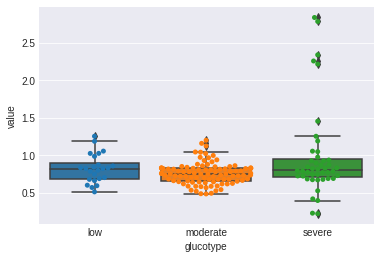

In [123]:
sns.swarmplot(x = "glucotype", y = "value", data = df_meta_gi)
sns.boxplot(x = "glucotype", y = "value", data = df_meta_gi)

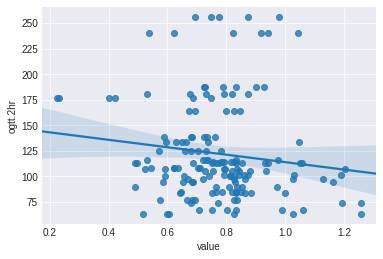

In [125]:
sns.regplot(x = "value", y = "ogtt.2hr", data = df_meta_gi)

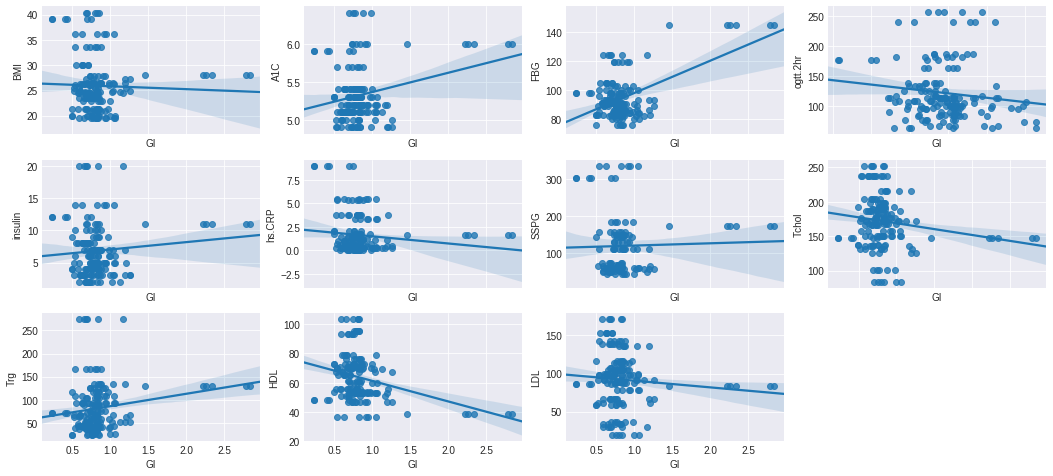

In [128]:
plt.figure(figsize=(18,8))

for i, clinical_var in enumerate(clinical_variables):
    
    plt.subplot(3,4, i+1)
    sns.regplot(x = "value", y = clinical_var, data = df_meta_gi)
    plt.xlabel("GI")
    if i < (12-4):
        plt.tick_params(labelbottom=False)

In [92]:
np.nanmedian(gis_pivot["Bar 1"])

0.7630057803468208

In [93]:
np.nanmedian(gis_pivot["Bar 2"])

0.772324448653768

In [95]:
np.nanmedian(gis_pivot["CF 1"])

0.7774237033233072

In [61]:
df_meals_ogtt.shape

(1390, 13)

In [62]:
ogtt_df.shape

(186, 5)

In [63]:
df_meals_ogtt_times.shape

(516, 9)

## load glucsoe

In [4]:
df_glucose = pd.read_csv("/data/glucolytes/S1_Data.tsv", sep = "\t")

df_glucose.head()

DisplayTime GlucoseValue    subjectId         InternalTime
0  2014-02-03 03:42:12           93  1636-69-001  2016-02-03 00:05:23
1  2014-02-03 03:47:12           93  1636-69-001  2016-02-03 00:10:23
2  2014-02-03 03:52:12           93  1636-69-001  2016-02-03 00:15:23
3  2014-02-03 03:57:12           95  1636-69-001  2016-02-03 00:20:23
4  2014-02-03 04:02:12           96  1636-69-001  2016-02-03 00:25:23

In [5]:
df_glucose.GlucoseValue = pd.to_numeric(df_glucose.GlucoseValue, errors="coerce")

df_glucose.index = pd.to_datetime(df_glucose.InternalTime)

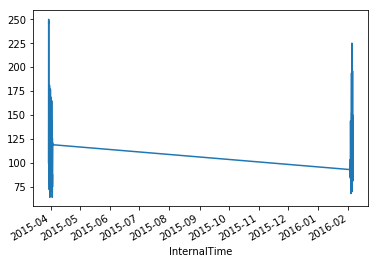

In [6]:
df_subject = df_glucose[df_glucose.subjectId== "1636-69-001"]

df_subject.GlucoseValue.plot()

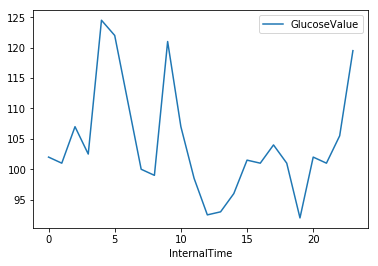

In [18]:
df_subject.groupby(df_subject.index.hour).median().plot()

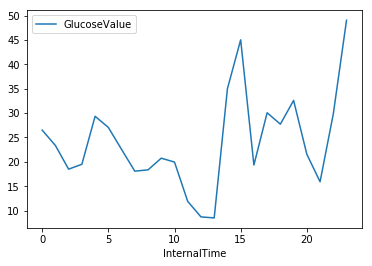

In [12]:
df_subject.groupby(df_subject.index.hour).apply(np.std).plot()

In [84]:
subjects = pd.unique(df_glucose.subjectId)

subject_hourly_glucose = []

for subject in subjects:
    df_subject = df_glucose[df_glucose.subjectId == subject]
    subject_hourly_glucose.append(df_subject.groupby(df_subject.index.hour).median().values)
    

In [90]:
df_subjects_hourly = pd.DataFrame(np.array(subject_hourly_glucose).squeeze())
df_subjects_hourly.columns = ["h"+ str(i) for i in range(24)]

In [91]:
df_subjects_hourly.index = subjects

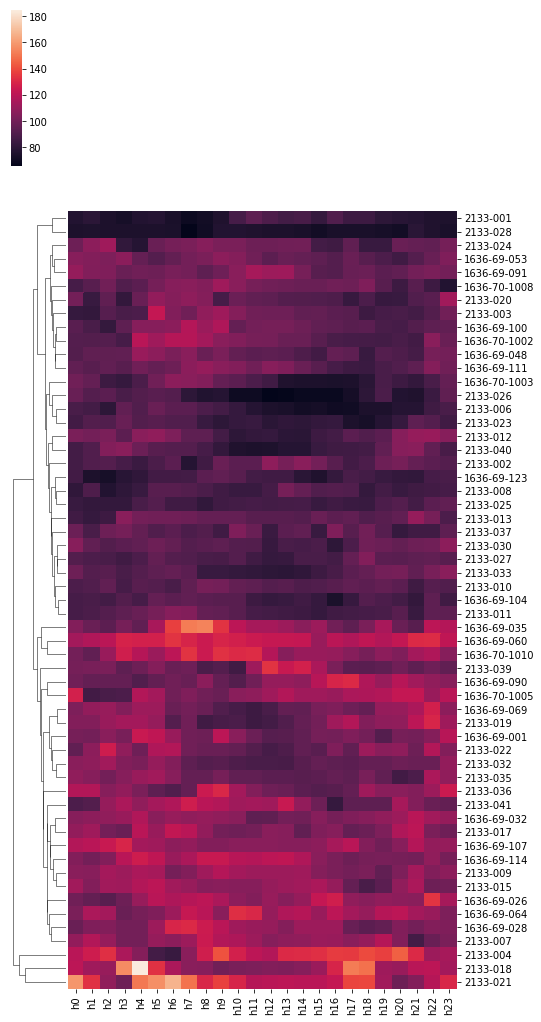

In [113]:
sns.clustermap(df_subjects_hourly, col_cluster=False, row_cluster=True, figsize=(8, 18));

In [123]:
subjects = pd.unique(df_glucose.subjectId)

subject_daily_glucose = {}

for subject in subjects:
    df_subject = df_glucose[df_glucose.subjectId == subject]
    daily_vals = df_subject.groupby(df_subject.index.dayofweek).median().values
    if len(daily_vals) == 7:
        subject_daily_glucose[subject] = daily_vals.squeeze()

    


In [125]:
df_subjects_daily = pd.DataFrame.from_dict(subject_daily_glucose, orient = "index")
df_subjects_daily.columns = ["d"+ str(i) for i in range(7)]

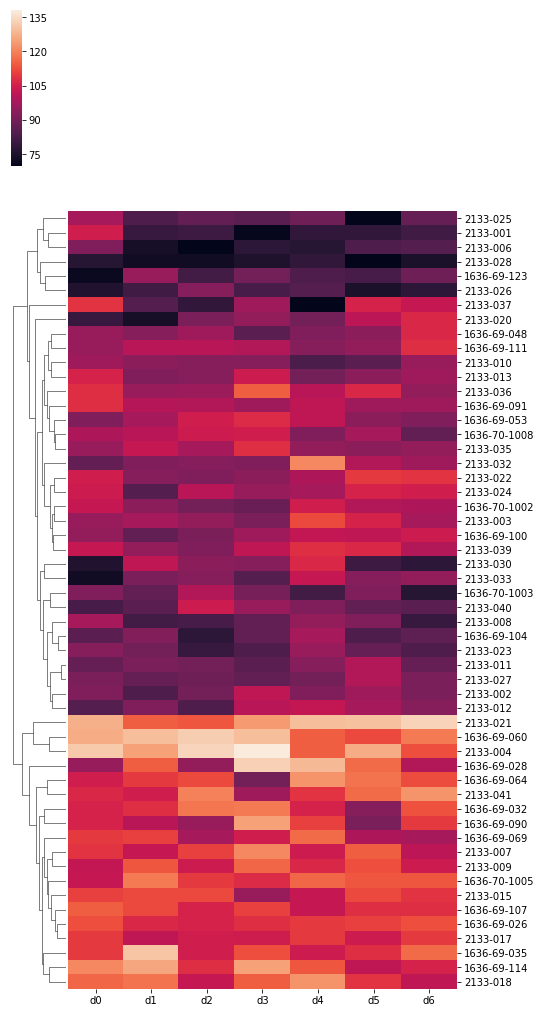

In [126]:
sns.clustermap(df_subjects_daily, col_cluster=False, row_cluster=True, figsize=(8, 18));

In [95]:
df_subjects_hourly.min()

h0     75.0
h1     75.0
h2     73.0
h3     73.0
h4     75.0
h5     75.0
h6     74.0
h7     66.5
h8     71.5
h9     76.0
h10    70.5
h11    70.5
h12    66.0
h13    67.0
h14    69.0
h15    69.0
h16    69.0
h17    71.5
h18    73.0
h19    73.0
h20    72.0
h21    76.0
h22    76.0
h23    74.0
dtype: float64

In [69]:
subjects_max_glucose = df_glucose.groupby("subjectId")["GlucoseValue"].min()

In [64]:
df_meta.index = df_meta.userID

In [65]:
subjects_max_glucose.index

Index(['1636-69-001', '1636-69-026', '1636-69-028', '1636-69-032',
       '1636-69-035', '1636-69-048', '1636-69-053', '1636-69-060',
       '1636-69-064', '1636-69-069', '1636-69-090', '1636-69-091',
       '1636-69-100', '1636-69-104', '1636-69-107', '1636-69-111',
       '1636-69-114', '1636-69-123', '1636-70-1002', '1636-70-1003',
       '1636-70-1005', '1636-70-1008', '1636-70-1010', '2133-001', '2133-002',
       '2133-003', '2133-004', '2133-006', '2133-007', '2133-008', '2133-009',
       '2133-010', '2133-011', '2133-012', '2133-013', '2133-015', '2133-017',
       '2133-018', '2133-019', '2133-020', '2133-021', '2133-022', '2133-023',
       '2133-024', '2133-025', '2133-026', '2133-027', '2133-028', '2133-030',
       '2133-032', '2133-033', '2133-035', '2133-036', '2133-037', '2133-039',
       '2133-040', '2133-041'],
      dtype='object', name='subjectId')

In [66]:
res = pd.merge(df_meta, pd.DataFrame(subjects_max_glucose), left_index=True, right_index=True)

In [67]:
res.columns

Index(['userID', 'Age', 'BMI', 'A1C', 'FBG', 'ogtt.2hr', 'insulin', 'hs.CRP',
       'Tchol', 'Trg', 'HDL', 'LDL', 'mean_glucose', 'sd_glucose',
       'range_glucose', 'min_glucose', 'max_glucose', 'quartile.25_glucose',
       'median_glucose', 'quartile.75_glucose', 'mean_slope', 'max_slope',
       'number_Random140', 'number_Random200', 'percent_below.80',
       'percent_above.130', 'se_glucose_mean', 'numGE', 'mage', 'j_index',
       'IQR', 'modd', 'distance_traveled', 'coef_variation',
       'number_Random140_normByDays', 'number_Random200_normByDays',
       'numGE_normByDays', 'distance_traveled_normByDays', 'diagnosis',
       'freq_low', 'freq_moderate', 'freq_severe', 'glucotype', 'Height',
       'Weight', 'Insulin_rate_dd', 'perc_cgm_prediabetic_range',
       'perc_cgm_diabetic_range', 'SSPG', 'GlucoseValue'],
      dtype='object')

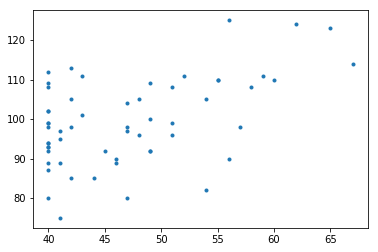

In [70]:
plt.plot(res.min_glucose, res.GlucoseValue, '.')

In [37]:
res[["max_glucose", "GlucoseValue"]].head()

max_glucose  GlucoseValue
userID                                
1636-69-001        339.0         250.0
1636-69-026        182.0         182.0
1636-69-028        216.0         216.0
1636-69-032        191.0         191.0
1636-69-035        234.0         234.0

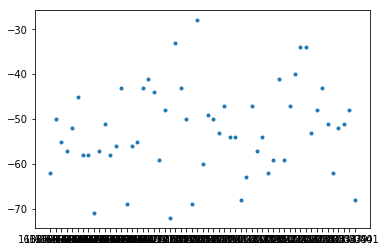

In [71]:
plt.plot(res.min_glucose - res.GlucoseValue, '.');

In [40]:
res.columns

Index(['userID', 'Age', 'BMI', 'A1C', 'FBG', 'ogtt.2hr', 'insulin', 'hs.CRP',
       'Tchol', 'Trg', 'HDL', 'LDL', 'mean_glucose', 'sd_glucose',
       'range_glucose', 'min_glucose', 'max_glucose', 'quartile.25_glucose',
       'median_glucose', 'quartile.75_glucose', 'mean_slope', 'max_slope',
       'number_Random140', 'number_Random200', 'percent_below.80',
       'percent_above.130', 'se_glucose_mean', 'numGE', 'mage', 'j_index',
       'IQR', 'modd', 'distance_traveled', 'coef_variation',
       'number_Random140_normByDays', 'number_Random200_normByDays',
       'numGE_normByDays', 'distance_traveled_normByDays', 'diagnosis',
       'freq_low', 'freq_moderate', 'freq_severe', 'glucotype', 'Height',
       'Weight', 'Insulin_rate_dd', 'perc_cgm_prediabetic_range',
       'perc_cgm_diabetic_range', 'SSPG', 'GlucoseValue'],
      dtype='object')

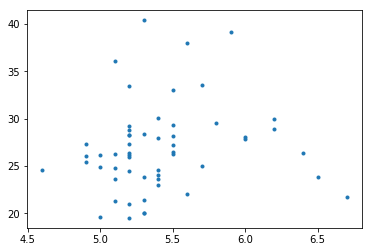

In [76]:
plt.plot(res.A1C, res.BMI, '.')

In [61]:
np.corrcoef(res.GlucoseValue, res.A)

array([[ 1., nan],
       [nan, nan]])

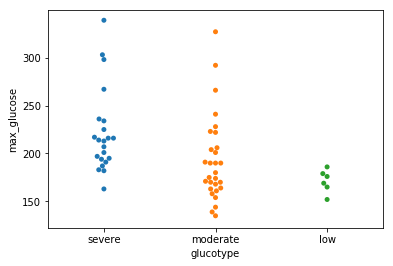

In [57]:
ax = sns.swarmplot(x = "glucotype", y = "max_glucose", data = res)

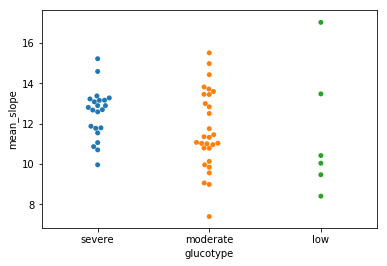

In [73]:
ax = sns.swarmplot(x = "glucotype", y = "mean_slope", data = res)

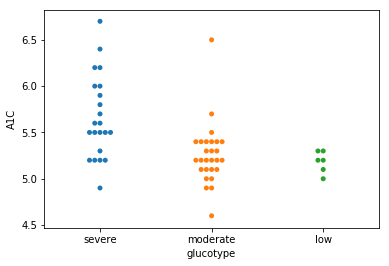

In [62]:
ax = sns.swarmplot(x = "glucotype", y = "A1C", data = res)

In [53]:
res.glucotype.value_counts()

moderate    29
severe      22
low          6
Name: glucotype, dtype: int64

Index(['userID', 'Age', 'BMI', 'A1C', 'FBG', 'ogtt.2hr', 'insulin', 'hs.CRP',
       'Tchol', 'Trg', 'HDL', 'LDL', 'mean_glucose', 'sd_glucose',
       'range_glucose', 'min_glucose', 'max_glucose', 'quartile.25_glucose',
       'median_glucose', 'quartile.75_glucose', 'mean_slope', 'max_slope',
       'number_Random140', 'number_Random200', 'percent_below.80',
       'percent_above.130', 'se_glucose_mean', 'numGE', 'mage', 'j_index',
       'IQR', 'modd', 'distance_traveled', 'coef_variation',
       'number_Random140_normByDays', 'number_Random200_normByDays',
       'numGE_normByDays', 'distance_traveled_normByDays', 'diagnosis',
       'freq_low', 'freq_moderate', 'freq_severe', 'glucotype', 'Height',
       'Weight', 'Insulin_rate_dd', 'perc_cgm_prediabetic_range',
       'perc_cgm_diabetic_range', 'SSPG'],
      dtype='object')